In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.misc import imread
import matplotlib as mpl
from skimage.feature import canny
from scipy.ndimage.filters import sobel
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
plt.ion()
# Good for the b/w test images used
import time
MIN_CANNY_THRESHOLD = 10
MAX_CANNY_THRESHOLD = 50

In [2]:
def gradient_orientation(image):
    '''
    Calculate the gradient orientation for edge point in the image
    '''
    dx = sobel(image, axis=0, mode='constant')
    dy = sobel(image, axis=1, mode='constant')
    gradient = np.arctan2(dy,dx) * 180 / np.pi
#     plt.imshow(gradient)
    return gradient

In [36]:
def build_r_table(image, origin):
    '''
    Build the R-table from the given shape image and a reference point
    '''
    edges = canny(image, low_threshold=MIN_CANNY_THRESHOLD, 
                  high_threshold=MAX_CANNY_THRESHOLD)
#     plt.figure()
#     plt.imshow(edges,cmap='gray')
    gradient = gradient_orientation(edges)
    
    r_table = defaultdict(list)
    for (i,j),value in np.ndenumerate(edges):
        if value:
#             print(origin[0]-i, origin[1]-j)
            r_table[gradient[i,j]].append((origin[0]-i, origin[1]-j))
    
    
    rtb = pd.DataFrame.from_dict(r_table, orient='index')
    rtb.to_csv(str(time.time())+'.csv')
    return r_table

In [19]:
def accumulate_gradients(r_table, grayImage):
    '''
    Perform a General Hough Transform with the given image and R-table
    '''
    edges = canny(grayImage, low_threshold=MIN_CANNY_THRESHOLD, 
                  high_threshold=MAX_CANNY_THRESHOLD)
    gradient = gradient_orientation(edges)
    
    accumulator = np.zeros(grayImage.shape)
    for (i,j),value in np.ndenumerate(edges):
        if value:
            if r_table[gradient[i,j]]:
                r_list=r_table[gradient[i,j]]
            else:
                angs=np.array(list(r_table.keys()))
#                 print(angs)
                angsgrad=np.abs(angs-gradient[i,j])
#                 print(angsgrad)
                minInd=np.argmin(angsgrad)
#                 print(minInd)
                nearest=list(r_table.keys())[minInd]
                r_list=r_table[nearest]
            for r in r_list:
                accum_i, accum_j = i+r[0], j+r[1]
                if accum_i < accumulator.shape[0] and accum_j < accumulator.shape[1]:
                    accumulator[accum_i][accum_j] += 1

#                     accumulator[int(accum_i)][int(accum_j)] += 1
                    
    return accumulator

In [5]:
def general_hough_closure(reference_image):
    '''
    Generator function to create a closure with the reference image and origin
    at the center of the reference image
    
    Returns a function f, which takes a query image and returns the accumulator
    '''
    referencePoint = (reference_image.shape[0]//2, reference_image.shape[1]//2)
    r_table = build_r_table(reference_image, referencePoint)
    
    def f(query_image):
        return accumulate_gradients(r_table, query_image)
        
    return f

In [6]:
def n_max(a, n):
    '''
    Return the N max elements and indices in a
    '''
    indices = a.ravel().argsort()[-n:]
    indices = (np.unravel_index(i, a.shape) for i in indices)
    return [(a[i], i) for i in indices]

In [7]:
def getInverseImage(img):
    return 255-img
def display(img):
    plt.figure()
    plt.imshow(img,cmap='gray')
def getBinary(img):
    return img>img.mean()
# def castMask(raw,mask):
#     raw[mask>0]=
def gray2rgb(gray_img):
    h,w=gray_img.shape
    gray_img=255*gray_img//gray_img.max()
    result=np.ones((h,w,3))
    for (i,j),v in np.ndenumerate(gray_img):
        result[i,j,:]*=v
    return result.astype(int)

def castMask(raw,mask):
    assert(raw.shape==mask.shape)
    result=gray2rgb(raw)
    for (i,j),v in np.ndenumerate(mask):
        if v>0:
            result[i,j,:]=[238,108,96]
    return result
def getRGBAMask(query,refer,location):
    color=np.append(np.random.rand(3,1),[0.6])
    H,W=query.shape
    m=np.zeros((H,W,4))
    I,J=location
    invQ=getInverseImage(query)

    invT=getInverseImage(refer)

    binInvT=getBinary(invT)

    h,w=binInvT.shape
    for (i,j),v in np.ndenumerate(binInvT):
    #     print(i,j,v)
        if v:
            m[I-h//2+i,J-w//2+j,:]=color
    return m
def getMask(query,refer,location):
    m=np.zeros(query.shape)
    I,J=location
    invQ=getInverseImage(query)
#     display(invQ)
    invT=getInverseImage(refer)
#     display(invT)
    binInvT=getBinary(invT)
#     display(binInvT)
    h,w=binInvT.shape
    for (i,j),v in np.ndenumerate(binInvT):
    #     print(i,j,v)
        m[I-h//2+i,J-w//2+j]=v
    return m

In [8]:
def test_general_hough(gh, reference_image, query):
    '''
    Uses a GH closure to detect shapes in an image and create nice output
    '''
    query_image = imread(query, flatten=True)
#     print(query_image.shape)
    accumulator = gh(query_image)
#     print(accumulator.min(),accumulator.max())
#     plt.clf()
#     plt.gray()

    plt.ion()
    
    fig = plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
    fig.add_subplot(2,3,1)
    plt.title('Reference image')
    plt.imshow(reference_image,cmap='gray')
    
    fig.add_subplot(2,3,2)
    plt.title('Query image')
    plt.imshow(query_image,cmap='gray')
    
    fig.add_subplot(2,3,3)
    plt.title('Accumulator')
    plt.imshow(accumulator,cmap='gray')
    
    fig.add_subplot(2,3,4)
    plt.title('Detection')
    
    m = n_max(accumulator, 10)
    y_points = [pt[1][0] for pt in m]
    x_points = [pt[1][1] for pt in m] 
#     plt.scatter(x_points, y_points, marker='o', color='r')

    # top result in yellow
    i,j = np.unravel_index(accumulator.argmax(), accumulator.shape)
#     plt.scatter([j], [i], marker='x', color='y')

    mask=getMask(query_image,reference_image,location=(i,j))
    masked=castMask(query_image,mask)
#     d,f = os.path.split(query)[0], os.path.splitext(os.path.split(query)[1])[0]
#     plt.savefig(os.path.join(d, f + '_output.png'))
    
    plt.imshow(masked)
    
    fig.add_subplot(2,3,5)
    plt.title('With Alpha Masked')
    plt.imshow(query_image,cmap='gray')
    plt.imshow(getRGBAMask(query_image,reference_image,location=(i,j)))

    
    return mask

In [9]:
def detectObjects(ghs, reference_images, query):
    '''
    Uses a GH closure to detect shapes in an image and create nice output
    '''
    query_image = imread(query, flatten=True)
#     print(query_image.shape)
    accumulators = [gh(query_image) for gh in ghs]

    plt.ion()
    rows,cols=len(reference_images),2
    fig1 = plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
#     fig1.title('Reference images')
    for i,img in enumerate(reference_images):
        fig1.add_subplot(rows,cols,(i+1)*2-1)
        plt.title('Refer {}'.format(i))
        plt.imshow(img,cmap='gray')
        fig1.add_subplot(rows,cols,(i+1)*2)
        plt.title('Accumulator {}'.format(i))
        plt.imshow(accumulators[i],cmap='gray')
    plt.tight_layout()
    
    fig2=plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
    fig2.add_subplot(1,2,1)
    plt.title('Query image')
    plt.imshow(query_image,cmap='gray')

    
    fig2.add_subplot(1,2,2)
    plt.title('Detection')
    plt.imshow(query_image,cmap='gray')
    for i,acc in enumerate(accumulators):
        img=reference_images[i]
        m = n_max(acc, 1)
        y_points = [pt[1][0] for pt in m]
        x_points = [pt[1][1] for pt in m] 
        for i,j in zip(y_points,x_points):

            plt.imshow(getRGBAMask(query_image,img,location=(i,j)))
        plt.tight_layout()

In [13]:
def demo1():
    filePathAtt='../../pics/final/'
    reference_image_list=[
        filePathAtt+"earphone.png",
        filePathAtt+"headphone.png",
        filePathAtt+"mouse.png",
        filePathAtt+"watch.png",
                         ]
    reference_images =[ imread(file, flatten=True) for file in reference_image_list]

    detect_s = [general_hough_closure(reference_image) for reference_image in reference_images]

    detectObjects(detect_s,reference_images,filePathAtt+"queryAll.png")
    
def demo2():
    filePathAtt='../../pics/final/'
    reference_image_list=[
        filePathAtt+"t1.png",
        filePathAtt+"t2.png",
        filePathAtt+"t3.png",
                         ]
    reference_images =[ imread(file, flatten=True) for file in reference_image_list]

    detect_s = [general_hough_closure(reference_image) for reference_image in reference_images]

    detectObjects(detect_s,reference_images,filePathAtt+"query1.png")

In [45]:
class ObjectFinder:
    def __init__(self,NamePath,Query):
        self.namePath=NamePath
        self.query=Query
        self.nameImage={}
        self.nameDetector={}
        for name,path in self.namePath.items():
            curImage=imread(path,flatten=True)
            curdetector=general_hough_closure(curImage)
            self.nameImage.update({name:curImage})
            self.nameDetector.update({name:curdetector})
            
    def detect(self):
        print("Please input one of the following name, Q/q for quit")
        print([it for it in self.namePath.keys()])
        ans=input("Object to detect/Q?:")
        if ans in ['Q','q']:
            return
        elif ans in list(self.nameImage.keys()):
            detectObjects([self.nameDetector[ans]],[self.nameImage[ans]],self.query)
#             self.detect()
            return
        else:
            print("Wrong name.")
            self.detect()

/Users/edwardchor/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


Please input one of the following name, Q/q for quit
['earphone', 'headphone', 'watch', 'mouse']


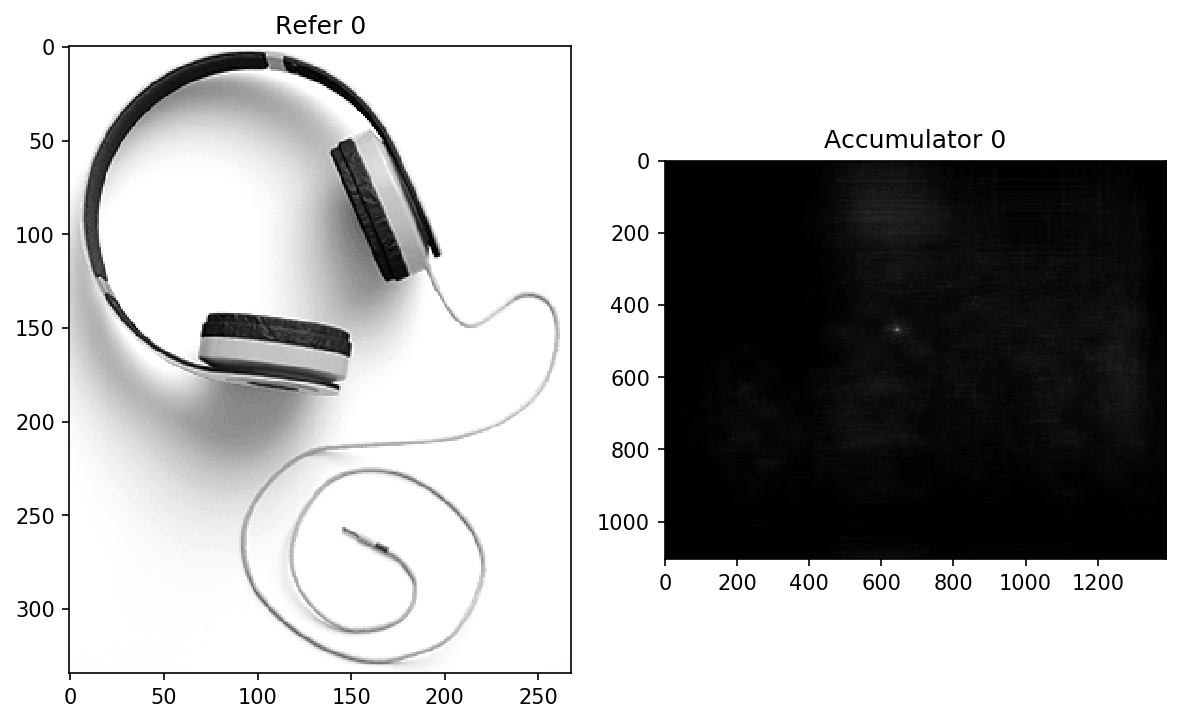

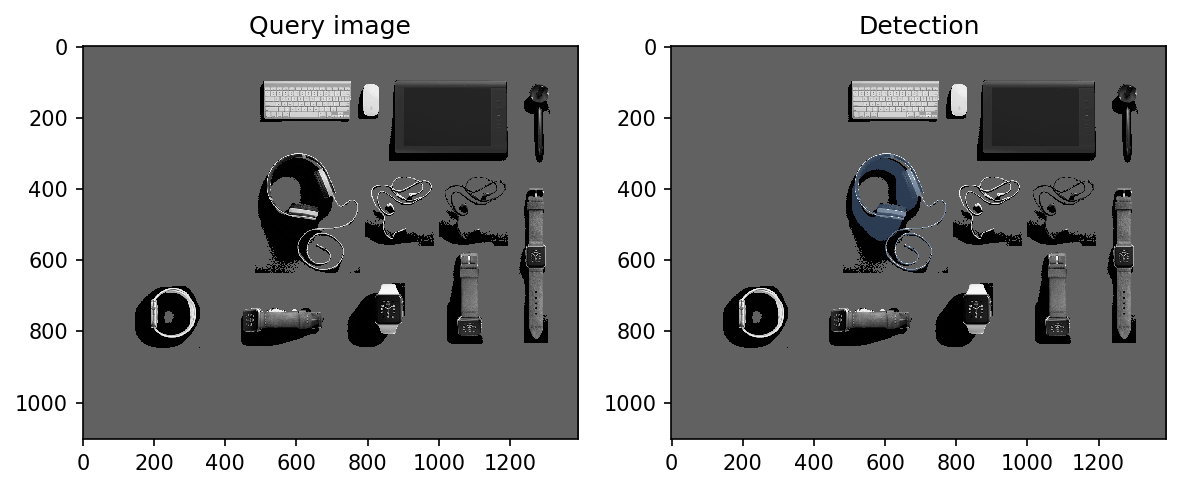

In [48]:
filePathAtt='../../pics/final/'
objList=['earphone','headphone','watch','mouse']
namepath={obj:filePathAtt+obj+'.png' for obj in objList}
q=filePathAtt+'queryAll.png'
Fdr=ObjectFinder(namepath,q)
Fdr.detect()